c:\users\chemi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\chemi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45804 (\N{HANGUL SYLLABLE DAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\chemi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\users\chemi\appdata\local\programs\python\python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


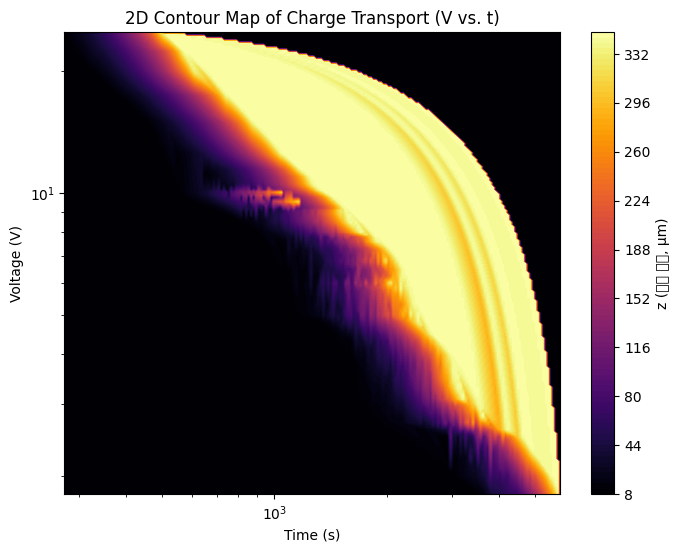

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata
from glob import glob

# Ïù¥ÎèôÌèâÍ∑† ÌïÑÌÑ∞ Ìï®Ïàò
def moving_average(data, window_size=5):
    return pd.Series(data).rolling(window=window_size, center=True, min_periods=1).mean().values

# Îç∞Ïù¥ÌÑ∞ ÎîîÎ†âÌÜ†Î¶¨ ÏÑ§Ï†ï
data_dir = "."  # Ïã§Ï†ú Í≤ΩÎ°úÎ°ú Î≥ÄÍ≤Ω
file_list = sorted(glob(os.path.join(data_dir, "*.dat")))

t_values = []  # ÏãúÍ∞Ñ Îç∞Ïù¥ÌÑ∞
V_values = []  # Ï†ÑÏïï Îç∞Ïù¥ÌÑ∞
z_values = []  # Í±∞Î¶¨ Îç∞Ïù¥ÌÑ∞

for file_path in file_list:
    # ÌååÏùºÎ™ÖÏóêÏÑú V Í∞í Ï∂îÏ∂ú
    try:
        V_value = float(os.path.basename(file_path).split("V")[0])
    except ValueError:
        continue  # ÌååÏùºÎ™ÖÏóêÏÑú Ïà´Ïûê Ï∂îÏ∂ú Ïã§Ìå® Ïãú Í±¥ÎÑàÎõ∞Í∏∞

    if V_value < 1.8:  # 1.8V ÎØ∏Îßå Îç∞Ïù¥ÌÑ∞ Î¨¥Ïãú
        continue
    
    df = pd.read_csv(file_path, sep=',', header=None, names=["z", "t"])
    df["z"] = 400 - df["z"]  # zÎ•º 400-zÎ°ú Î≥ÄÌôò
    
    df = df.groupby("t").mean().reset_index()  # Ï§ëÎ≥µÎêú tÍ∞í ÌèâÍ∑† Ï≤òÎ¶¨
    
    t_values.extend(df["t"].values)
    V_values.extend([V_value] * len(df))
    z_values.extend(moving_average(df["z"].values))  # Ïù¥ÎèôÌèâÍ∑† Ï†ÅÏö©

# t Í∞íÏù¥ 0Ïùº Í≤ΩÏö∞ logscale Ïò§Î•ò Î∞©ÏßÄ
t_min = min([t for t in t_values if t > 0])
t_grid = np.logspace(np.log10(t_min), np.log10(max(t_values)), 200)
V_grid = np.logspace(np.log10(min(V_values)), np.log10(max(V_values)), 200)

# 2D Grid ÏÉùÏÑ±
T, V = np.meshgrid(t_grid, V_grid)
Z = griddata((t_values, V_values), z_values, (T, V), method='linear')

# NaN Í∞í Î≥¥Ï†ï (ÏÑ†Ìòï Î≥¥Í∞Ñ Ï§ë NaN Î∞úÏÉù Î∞©ÏßÄ)
Z = np.nan_to_num(Z, nan=np.nanmin(Z))

# Ïπ∏ÌÜ†Ïñ¥ ÌîåÎ°Ø
plt.figure(figsize=(8, 6))
c = plt.contourf(T, V, Z, levels=100, cmap='inferno')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(c, label='z (ÎèÑÎã¨ Í±∞Î¶¨, Œºm)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('2D Contour Map of Charge Transport (V vs. t)')
plt.show()


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

# Îç∞Ïù¥ÌÑ∞ ÎîîÎ†âÌÜ†Î¶¨ ÏÑ§Ï†ï (ÌòÑÏû¨ Ìè¥Îçî Í∏∞Ï§Ä)
data_dir = "."
file_list = sorted([f for f in os.listdir(data_dir) if f.endswith(".dat")])

L = 400  # Œºm

V_all, t_all, z_all = [], [], []  # Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•Ïö©

# **1Îã®Í≥Ñ: ÌååÏùº ÏùΩÍ∏∞ Î∞è Îç∞Ïù¥ÌÑ∞ ÏàòÏßë**
for file in file_list:
    file_path = os.path.join(data_dir, file)
    V_value = float(os.path.basename(file).split("V")[0])  # ÌååÏùºÎ™ÖÏóêÏÑú V Ï∂îÏ∂ú
    
    if V_value < 1.8:  # 1.8V ÎØ∏Îßå Îç∞Ïù¥ÌÑ∞ Î¨¥Ïãú
        continue
    
    df = pd.read_csv(file_path, sep=',', header=None, names=["z", "t"])
    df["z"] = L - df["z"]  # zÎ•º 400-zÎ°ú Î≥ÄÌôò
    df = df.groupby("t").mean().reset_index()  # Ï§ëÎ≥µÎêú tÍ∞í ÌèâÍ∑† Ï≤òÎ¶¨

    V_all.extend([V_value] * len(df))
    t_all.extend(df["t"].values)
    z_all.extend(df["z"].values)

# NumPy Î∞∞Ïó¥ Î≥ÄÌôò
V_all = np.array(V_all)
t_all = np.array(t_all)
z_all = np.array(z_all)

# **2Îã®Í≥Ñ: ÌîºÌåÖÏùÑ ÏúÑÌïú Ìï®Ïàò Ï†ïÏùò**
def z_model(t, mu, t0, V):
    val = L**2 - 2 * V * mu * (t - t0)
    val = np.maximum(val, 0)  # ÏùåÏàò Î∞©ÏßÄ
    return L - np.sqrt(val)

# **3Îã®Í≥Ñ: VÎ≥ÑÎ°ú mu, t0 ÌîºÌåÖ ÌõÑ Ïù¥ÏÉÅÏπò Ï†úÍ±∞**
filtered_V, filtered_t, filtered_z = [], [], []
unique_Vs = np.unique(V_all)

for V in unique_Vs:
    mask = V_all == V
    t_values = t_all[mask]
    z_values = z_all[mask]
    
    # Ï¥àÍ∏∞ Ï∂îÏ†ïÍ∞í ÏÑ§Ï†ï
    mu_guess = (max(z_values) - min(z_values)) / (max(t_values) - min(t_values))
    t0_guess = min(t_values) * 0.99  

    try:
        popt, _ = curve_fit(lambda t, mu, t0: z_model(t, mu, t0, V), t_values, z_values, p0=[mu_guess, t0_guess])
        mu_opt, t0_opt = popt
        print(f"{V}VÌîºÌåÖÏÑ±Í≥µ")
    except:
        print(f"‚ö†Ô∏è {V}VÏóêÏÑú ÌîºÌåÖ Ïã§Ìå®! Ìï¥Îãπ Îç∞Ïù¥ÌÑ∞ Ïú†ÏßÄÌï®.")
        mu_opt, t0_opt = mu_guess, t0_guess  # Ïã§Ìå® Ïãú Ï¥àÍ∏∞Í∞í ÏÇ¨Ïö©
    
    # Ïù¥ÏÉÅÏπò Ï†úÍ±∞
    z_theory = z_model(t_values, mu_opt, t0_opt, V)
    error = np.abs(z_values - z_theory)
    threshold = np.mean(error) + 3 * np.std(error)  # ÌèâÍ∑† + 3œÉ Ïù¥ÏÉÅ Ï†úÍ±∞
    valid_mask = error < threshold

    filtered_V.extend(V_all[mask][valid_mask])
    filtered_t.extend(t_values[valid_mask])
    filtered_z.extend(z_values[valid_mask])

# **4Îã®Í≥Ñ: CSV ÌååÏùºÎ°ú Ï†ÄÏû•**
output_df = pd.DataFrame({"V": filtered_V, "t": filtered_t, "z": filtered_z})
output_df.to_csv("filtered_data.csv", index=False)

print("Filtered data saved to 'filtered_data.csv'")


1.8VÌîºÌåÖÏÑ±Í≥µ
2.0VÌîºÌåÖÏÑ±Í≥µ
2.3VÌîºÌåÖÏÑ±Í≥µ
2.5VÌîºÌåÖÏÑ±Í≥µ
2.6VÌîºÌåÖÏÑ±Í≥µ
2.7VÌîºÌåÖÏÑ±Í≥µ
2.8VÌîºÌåÖÏÑ±Í≥µ
3.0VÌîºÌåÖÏÑ±Í≥µ
3.1VÌîºÌåÖÏÑ±Í≥µ
3.3VÌîºÌåÖÏÑ±Í≥µ
3.5VÌîºÌåÖÏÑ±Í≥µ
3.8VÌîºÌåÖÏÑ±Í≥µ
4.0VÌîºÌåÖÏÑ±Í≥µ
4.3VÌîºÌåÖÏÑ±Í≥µ
4.5VÌîºÌåÖÏÑ±Í≥µ
4.8VÌîºÌåÖÏÑ±Í≥µ
5.0VÌîºÌåÖÏÑ±Í≥µ
‚ö†Ô∏è 5.3VÏóêÏÑú ÌîºÌåÖ Ïã§Ìå®! Ìï¥Îãπ Îç∞Ïù¥ÌÑ∞ Ïú†ÏßÄÌï®.
5.8VÌîºÌåÖÏÑ±Í≥µ
6.0VÌîºÌåÖÏÑ±Í≥µ
6.2VÌîºÌåÖÏÑ±Í≥µ
6.5VÌîºÌåÖÏÑ±Í≥µ
6.8VÌîºÌåÖÏÑ±Í≥µ
7.0VÌîºÌåÖÏÑ±Í≥µ
7.3VÌîºÌåÖÏÑ±Í≥µ
7.6VÌîºÌåÖÏÑ±Í≥µ
7.8VÌîºÌåÖÏÑ±Í≥µ
8.0VÌîºÌåÖÏÑ±Í≥µ
8.5VÌîºÌåÖÏÑ±Í≥µ
9.0VÌîºÌåÖÏÑ±Í≥µ
9.2VÌîºÌåÖÏÑ±Í≥µ
9.5VÌîºÌåÖÏÑ±Í≥µ
9.8VÌîºÌåÖÏÑ±Í≥µ
10.0VÌîºÌåÖÏÑ±Í≥µ
10.2VÌîºÌåÖÏÑ±Í≥µ
10.5VÌîºÌåÖÏÑ±Í≥µ
11.0VÌîºÌåÖÏÑ±Í≥µ
11.5VÌîºÌåÖÏÑ±Í≥µ
12.5VÌîºÌåÖÏÑ±Í≥µ
15.0VÌîºÌåÖÏÑ±Í≥µ
17.5VÌîºÌåÖÏÑ±Í≥µ
20.0VÌîºÌåÖÏÑ±Í≥µ
22.5VÌîºÌåÖÏÑ±Í≥µ
25.0VÌîºÌåÖÏÑ±Í≥µ
Filtered data saved to 'filtered_data.csv'


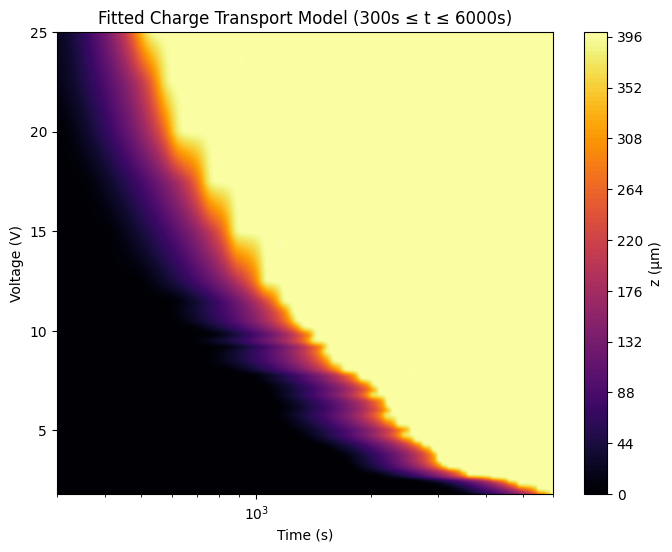

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: fittings.csv Î°úÎìú & Î≥¥Í∞Ñ**
fitting_df = pd.read_csv("fittings.csv")

V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # **cm¬≤ ‚Üí ¬µm¬≤ Î≥ÄÌôò**

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2Îã®Í≥Ñ: ÌîºÌåÖ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±**
L = 400  # Œºm
t_grid = np.linspace(300, 6000, 400)  # **üìå Ï†ê Í∞úÏàòÎ•º 200 ‚Üí 400Í∞úÎ°ú Ï¶ùÍ∞Ä**
V_grid = np.linspace(min(V_values), max(V_values), 400)

V_list, t_list, z_list = [], [], []

for V, t0, mu in zip(V_values, t0_values, mu_values):
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)  # **0~400 ŒºmÎ°ú ÌÅ¥Î¶¨Ìïë**

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3Îã®Í≥Ñ: 2D Grid Î≥¥Í∞Ñ**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = griddata((t_list, V_list), z_list, (T_grid, V_grid), method='linear')  # üìå **cubic ‚Üí linear**

# **4Îã®Í≥Ñ: Gaussian ÌïÑÌÑ∞Î°ú smoothing**
Z_grid = gaussian_filter(Z_grid, sigma=1.5)  # **üìå Ïä§Î¨¥Îî© Ï†ÅÏö©**

# **5Îã®Í≥Ñ: Ïª¨Îü¨Îßµ Í∑∏Î¶¨Í∏∞**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='inferno')
plt.xscale("log")
plt.colorbar(c, label="z (Œºm)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model (300s ‚â§ t ‚â§ 6000s)")
plt.xlim(300, 6000)  # üìå xÏ∂ï Î≤îÏúÑ Ï†úÌïú
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: fittings.csv Î°úÎìú & Î≥¥Í∞Ñ**
fitting_df = pd.read_csv("fittings.csv")

V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # **cm¬≤ ‚Üí ¬µm¬≤ Î≥ÄÌôò**

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±**
L = 400  # Œºm

V_list, t_list, z_list = [], [], []

for V, t0, mu in zip(V_values, t0_values, mu_values):
    # **Ï†ÅÏùëÌòï t_grid ÏÉùÏÑ±**
    t1 = t0 + L**2 / (2 * V * mu)  # z = LÏóê ÎèÑÎã¨ÌïòÎäî ÏãúÍ∞Ñ
    t_moving = np.linspace(t0, t1, 200)  # Ïù¥Îèô Ï§ë Íµ¨Í∞ÑÏùÑ Ï¥òÏ¥òÌïòÍ≤å
    t_later = np.linspace(t1, 6000, 50)  # Ïù¥ÌõÑ Íµ¨Í∞ÑÏùÑ Îì¨ÏÑ±Îì¨ÏÑ±

    t_grid = np.concatenate(([0], [t0], t_moving, t_later))  # Ï¥àÍ∏∞Í∞í Ìè¨Ìï®

    # **Ïù¥Ïò® Ïù¥Îèô Î™®Îç∏ Ï†ÅÏö©**
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)  # **0~400 ŒºmÎ°ú ÌÅ¥Î¶¨Ìïë**

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3Îã®Í≥Ñ: 2D Grid Î≥¥Í∞Ñ**
T_grid, V_grid = np.meshgrid(np.logspace(np.log10(300), np.log10(6000), 100), np.linspace(min(V_values), max(V_values), 100))
Z_grid = griddata((t_list, V_list), z_list, (T_grid, V_grid), method='linear')

# **4Îã®Í≥Ñ: Gaussian ÌïÑÌÑ∞Î°ú smoothing**
Z_grid = gaussian_filter(Z_grid, sigma=1.5)

# **5Îã®Í≥Ñ: Ïª¨Îü¨Îßµ Í∑∏Î¶¨Í∏∞**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='inferno')
plt.xscale("log")
plt.colorbar(c, label="z (Œºm)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model")
plt.xlim(300, 6000)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
for V, t0, mu in zip(V_values, t0_values, mu_values):
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3Îã®Í≥Ñ: Ï§ëÎ≥µ Îç∞Ïù¥ÌÑ∞ Ï†úÍ±∞**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

# **4Îã®Í≥Ñ: RBF Î≥¥Í∞Ñ**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò epsilon ÏÑ§Ï†ï
)

# **5Îã®Í≥Ñ: Î≥¥Í∞ÑÎêú Grid ÏÉùÏÑ±**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **6Îã®Í≥Ñ: Gaussian ÌïÑÌÑ∞ Ï†ÅÏö©**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **7Îã®Í≥Ñ: Í∑∏ÎûòÌîÑ Ï∂úÎ†•**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')
# plt.xscale("log")
plt.yscale("log")
plt.colorbar(c, label="z (Œºm)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model (Fixed RBF Interpolation)")
plt.xlim(300, 6000)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
t_f_values = []  # ÏµúÏ¢Ö ÎèÑÎã¨ ÏãúÍ∞Ñ Ï†ÄÏû•

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f Í≥ÑÏÇ∞
    t_f_values.append(t_f)  # Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3Îã®Í≥Ñ: Ï§ëÎ≥µ Îç∞Ïù¥ÌÑ∞ Ï†úÍ±∞**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

# **4Îã®Í≥Ñ: RBF Î≥¥Í∞Ñ**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò epsilon ÏÑ§Ï†ï
)

# **5Îã®Í≥Ñ: Î≥¥Í∞ÑÎêú Grid ÏÉùÏÑ±**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **6Îã®Í≥Ñ: Gaussian ÌïÑÌÑ∞ Ï†ÅÏö©**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **7Îã®Í≥Ñ: Í∑∏ÎûòÌîÑ Ï∂úÎ†•**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='inferno')
plt.xscale("log")
plt.colorbar(c, label="z (Œºm)")

# **8Îã®Í≥Ñ: t0 Î∞è t_f Í∞í Ï∂îÍ∞Ä**
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # Ìù∞ÏÉâ Ïõê
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # ÌååÎûÄÏÉâ X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 1000)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
t_f_values = []  # ÏµúÏ¢Ö ÎèÑÎã¨ ÏãúÍ∞Ñ Ï†ÄÏû•

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f Í≥ÑÏÇ∞
    t_f_values.append(t_f)  # Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3Îã®Í≥Ñ: Ï§ëÎ≥µ Îç∞Ïù¥ÌÑ∞ Ï†úÍ±∞**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (Œºm)": z_list})
export_df.to_csv("data_export.csv", index=False)

# **4Îã®Í≥Ñ: RBF Î≥¥Í∞Ñ**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò epsilon ÏÑ§Ï†ï
)


# **5Îã®Í≥Ñ: Î≥¥Í∞ÑÎêú Grid ÏÉùÏÑ±**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **6Îã®Í≥Ñ: Gaussian ÌïÑÌÑ∞ Ï†ÅÏö©**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)
cmap_main = plt.get_cmap("inferno")  # Í∏∞Ï°¥ Ïª¨Îü¨Îßµ
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)
# **7Îã®Í≥Ñ: Í∑∏ÎûòÌîÑ Ï∂úÎ†•**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')
# **4Îã®Í≥Ñ: Ïª®Ìà¨Ïñ¥ ÎùºÏù∏ Ï∂îÍ∞Ä (z=0 Í∞ïÏ°∞)**
contour_levels = [5, 50, 100, 200, 300]
# plt.contour(T_grid, V_grid, Z_grid, levels=contour_levels, colors="white", linewidths=0.8)


plt.yscale("log")
plt.colorbar(c, label="z (Œºm)")

# **8Îã®Í≥Ñ: t0 Î∞è t_f Í∞í Ï∂îÍ∞Ä**
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # Ìù∞ÏÉâ Ïõê
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # ÌååÎûÄÏÉâ X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
t_f_values = []  # ÏµúÏ¢Ö ÎèÑÎã¨ ÏãúÍ∞Ñ Ï†ÄÏû•

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f Í≥ÑÏÇ∞
    t_f_values.append(t_f)  # Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3Îã®Í≥Ñ: RBF Î≥¥Í∞Ñ**
interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="linear",  # linearÎ°ú Î≥ÄÍ≤ΩÌïòÏó¨ Î∂ÄÎìúÎü¨Ïö¥ Î≥ÄÌôî
    epsilon=500  # Ï†ÅÏ†àÌïú smoothing (Îç∞Ïù¥ÌÑ∞Ïóê Îî∞Îùº Ï°∞Ï†ï Í∞ÄÎä•)
)

# **4Îã®Í≥Ñ: Î≥¥Í∞ÑÎêú Grid ÏÉùÏÑ±**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **5Îã®Í≥Ñ: Gaussian ÌïÑÌÑ∞ Ï†ÅÏö©ÌïòÏó¨ Î∂ÄÎìúÎüΩÍ≤å**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.5)

# **6Îã®Í≥Ñ: Ïª¨Îü¨Îßµ ÏÑ§Ï†ï**
cmap = plt.get_cmap("plasma")  
norm = colors.Normalize(vmin=0, vmax=400)

# **7Îã®Í≥Ñ: Í∑∏ÎûòÌîÑ Ï∂úÎ†•**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap=cmap, norm=norm)

# **8Îã®Í≥Ñ: t0 Î∞è t_f Í∞í Ï∂îÍ∞Ä**
plt.scatter(t0_values, V_values, color="white", marker="o", edgecolors="none", label="t0 values")  # Ìù∞ÏÉâ Ïõê
plt.scatter(t_f_values, V_values, color="cyan", marker="x", edgecolors="none", label="t_f values")  # ÌååÎûÄÏÉâ X

plt.xscale("log")
plt.colorbar(c, label="z (Œºm)")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_unique = np.unique(V_values)  # Î≥¥Í∞Ñ ÏóÜÏù¥ ÏõêÎûò V Í∞íÎßå ÏÇ¨Ïö©

V_list, t_list, z_list = [], [], []
t_f_values = []  # ÏµúÏ¢Ö ÎèÑÎã¨ ÏãúÍ∞Ñ Ï†ÄÏû•

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f Í≥ÑÏÇ∞
    t_f_values.append(t_f)  # Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)


# **4Îã®Í≥Ñ: Ï§ëÎ≥µ Îç∞Ïù¥ÌÑ∞ Ï†úÍ±∞**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]
# **3Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ CSVÎ°ú Ï†ÄÏû•**
export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (Œºm)": z_list})
export_df.to_csv("data_export2.csv", index=False)

# **5Îã®Í≥Ñ: RBF Î≥¥Í∞Ñ**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò epsilon ÏÑ§Ï†ï
)

# **6Îã®Í≥Ñ: Î≥¥Í∞ÑÎêú Grid ÏÉùÏÑ± (V Í∞í Î≥¥Í∞Ñ ÏóÜÏù¥ ÏõêÎûò Í∞íÎßå ÏÇ¨Ïö©)**
T_grid, V_grid = np.meshgrid(t_grid, V_unique)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **7Îã®Í≥Ñ: Gaussian ÌïÑÌÑ∞ Ï†ÅÏö©**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **8Îã®Í≥Ñ: Ïª¨Îü¨Îßµ ÏÑ§Ï†ï**
cmap_main = plt.get_cmap("inferno")  # Í∏∞Ï°¥ Ïª¨Îü¨Îßµ
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

# **9Îã®Í≥Ñ: Í∑∏ÎûòÌîÑ Ï∂úÎ†•**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')

# **10Îã®Í≥Ñ: Î°úÍ∑∏ Ïä§ÏºÄÏùº, Ïª¨Îü¨Î∞î, t0 Î∞è t_f Í∞í Ï∂îÍ∞Ä**
plt.yscale("log")
plt.colorbar(c, label="z (Œºm)")
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # Ìù∞ÏÉâ Ïõê
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # ÌååÎûÄÏÉâ X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings_filled.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_unique = np.unique(V_values)  # Î≥¥Í∞Ñ ÏóÜÏù¥ ÏõêÎûò V Í∞íÎßå ÏÇ¨Ïö©

V_list, t_list, z_list = [], [], []
t_f_values = []  # ÏµúÏ¢Ö ÎèÑÎã¨ ÏãúÍ∞Ñ Ï†ÄÏû•

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f Í≥ÑÏÇ∞
    t_f_values.append(t_f)  # Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3Îã®Í≥Ñ: Ï§ëÎ≥µ Îç∞Ïù¥ÌÑ∞ Ï†úÍ±∞**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

# **4Îã®Í≥Ñ: Ï§ëÎ≥µ Ï†úÍ±∞ ÌõÑ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•**
export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (Œºm)": z_list})
export_df.to_csv("data_export3.csv", index=False)

# **5Îã®Í≥Ñ: t0 Î∞è t_f Í∞í Ï†ÄÏû• (ÏõêÎûò Ï£ºÏñ¥ÏßÑ VÏóê ÎåÄÌï¥ÏÑúÎßå)**
t0_t_f_df = pd.DataFrame({"Voltage (V)": V_values, "t0 (s)": t0_values, "t_f (s)": t_f_values})
t0_t_f_df.to_csv("t0_tf_export.csv", index=False)

# **6Îã®Í≥Ñ: RBF Î≥¥Í∞Ñ**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò epsilon ÏÑ§Ï†ï
)

# **7Îã®Í≥Ñ: Î≥¥Í∞ÑÎêú Grid ÏÉùÏÑ± (V Í∞í Î≥¥Í∞Ñ ÏóÜÏù¥ ÏõêÎûò Í∞íÎßå ÏÇ¨Ïö©)**
T_grid, V_grid = np.meshgrid(t_grid, V_unique)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **8Îã®Í≥Ñ: Gaussian ÌïÑÌÑ∞ Ï†ÅÏö©**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **9Îã®Í≥Ñ: Ïª¨Îü¨Îßµ ÏÑ§Ï†ï**
cmap_main = plt.get_cmap("inferno")  # Í∏∞Ï°¥ Ïª¨Îü¨Îßµ
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

# **10Îã®Í≥Ñ: Í∑∏ÎûòÌîÑ Ï∂úÎ†•**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')

# **11Îã®Í≥Ñ: Î°úÍ∑∏ Ïä§ÏºÄÏùº, Ïª¨Îü¨Î∞î, t0 Î∞è t_f Í∞í Ï∂îÍ∞Ä**
plt.yscale("log")
plt.colorbar(c, label="z (Œºm)")
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # Ìù∞ÏÉâ Ïõê
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # ÌååÎûÄÏÉâ X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

# **2Îã®Í≥Ñ: V Î≤îÏúÑÏóê Îî∞Îùº ÏÉàÎ°úÏö¥ V_fine ÏÉùÏÑ±**
V_low = np.arange(1, 3, 0.1)  # 3V ÎØ∏Îßå: 0.1V Í∞ÑÍ≤©
V_high = np.arange(11.5, max(V_values) + 5, 0.25)  # 11.5V Ïù¥ÏÉÅ: 0.25V Í∞ÑÍ≤©
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]  # 3V Ïù¥ÏÉÅ 11.5V ÎØ∏Îßå: Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Ïú†ÏßÄ

V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# **3Îã®Í≥Ñ: t0ÏôÄ muÏùò Î≥¥Í∞Ñ**
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# **4Îã®Í≥Ñ: t_f Î∞è z Í≥ÑÏÇ∞**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)

V_list, t_list, z_list = [], [], []
t_f_values = []

z_map = {}

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    t_f = t0 + (L**2) / (2 * V * mu)  
    t_f_values.append(t_f)

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

    z_map[V] = interp1d(t_grid, z_values, kind="linear", bounds_error=False, fill_value="extrapolate")

# **5Îã®Í≥Ñ: Ï§ëÎ≥µ Ï†úÍ±∞ Î∞è Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (Œºm)": z_list})
export_df.to_csv("data_export4.csv", index=False)

# **6Îã®Í≥Ñ: t0 Î∞è t_f Í∞í Ï†ÄÏû•**
t0_t_f_df = pd.DataFrame({"Voltage (V)": V_fine, "t0 (s)": t0_fine, "t_f (s)": t_f_values})
t0_t_f_df.to_csv("t0_tf_export4.csv", index=False)

# **7Îã®Í≥Ñ: Grid ÏÉùÏÑ± Î∞è ÌîåÎ°úÌåÖ**
T_grid, V_grid = np.meshgrid(t_grid, V_fine)
Z_grid = np.zeros_like(T_grid)

for i, V in enumerate(V_fine):
    Z_grid[i, :] = z_map[V](t_grid)

Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=0.5)

cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap=custom_cmap)

plt.xscale("log")
plt.colorbar(c, label="z (Œºm)")
plt.scatter(t0_fine, V_fine, color="white", marker="o", label="t0 values")
plt.scatter(t_f_values, V_fine, color="cyan", marker="x", label="t_f values")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model (Adaptive Linear Interpolation)")
plt.xlim(300, 6000)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

# **2Îã®Í≥Ñ: V Î≤îÏúÑÏóê Îî∞Îùº ÏÉàÎ°úÏö¥ V_fine ÏÉùÏÑ±**
V_low = np.arange(1, 3, 0.1)  # 3V ÎØ∏Îßå: 0.1V Í∞ÑÍ≤©
V_high = np.arange(11.5, max(V_values) + 5, 0.25)  # 11.5V Ïù¥ÏÉÅ: 0.25V Í∞ÑÍ≤©
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]  # 3V Ïù¥ÏÉÅ 11.5V ÎØ∏Îßå: Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Ïú†ÏßÄ

V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# **3Îã®Í≥Ñ: t0ÏôÄ muÏùò Î≥¥Í∞Ñ**
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# **4Îã®Í≥Ñ: t_f Î∞è z Í≥ÑÏÇ∞**
L = 400  
t_grid = np.logspace(np.log10(10), np.log10(6000), 1000)

V_list, t_list, z_list = [], [], []
t_f_values = []

z_map = {}

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    t_f = t0 + (L**2) / (2 * V * mu)  
    t_f_values.append(t_f)

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

    z_map[V] = interp1d(t_grid, z_values, kind="linear", bounds_error=False, fill_value="extrapolate")

# **5Îã®Í≥Ñ: Ï§ëÎ≥µ Ï†úÍ±∞ Î∞è Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (Œºm)": z_list})
export_df.to_csv("data_export5.csv", index=False)

# **6Îã®Í≥Ñ: t0 Î∞è t_f Í∞í Ï†ÄÏû•**
t0_t_f_df = pd.DataFrame({"Voltage (V)": V_fine, "t0 (s)": t0_fine, "t_f (s)": t_f_values})
t0_t_f_df.to_csv("t0_tf_export5.csv", index=False)

# **7Îã®Í≥Ñ: Grid ÏÉùÏÑ± Î∞è ÌîåÎ°úÌåÖ**
T_grid, V_grid = np.meshgrid(t_grid, V_fine)
Z_grid = np.zeros_like(T_grid)

for i, V in enumerate(V_fine):
    Z_grid[i, :] = z_map[V](t_grid)

Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=0.5)

cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap=custom_cmap)

plt.xscale("log")
plt.colorbar(c, label="z (Œºm)")
plt.scatter(t0_fine, V_fine, color="white", marker="o", label="t0 values")
plt.scatter(t_f_values, V_fine, color="cyan", marker="x", label="t_f values")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model (Adaptive Linear Interpolation)")
plt.xlim(300, 6000)
plt.legend()
plt.show()

In [ ]:
import numpy as np
import csv

def interpolate_color(start, end, steps):
    """startÏóêÏÑú endÎ°ú ÏÑ†Ìòï Î≥¥Í∞ÑÎêú RGB Í∞íÏùÑ ÏÉùÏÑ±"""
    return np.linspace(start, end, steps, dtype=int)

# ÏÉâÏÉÅ Î≥ÄÌôò Íµ¨Í∞Ñ ÏÑ§Ï†ï
color_stops = [
    (255, 0, 0),   # Îπ®Í∞ï
    (255, 255, 0), # ÎÖ∏Îûë
    (0, 255, 0),   # Ï¥àÎ°ù
    (0, 255, 255), # ÏãúÏïà
    (0, 0, 255)    # ÌååÎûë
]

# 4Í∞úÏùò Íµ¨Í∞ÑÏúºÎ°ú 255Í∞ú Ï†êÏùÑ Í∑†Îì± Î∂ÑÎ∞∞
num_steps = [11, 11, 11, 11]  # Ï¥ù 255Í∞úÍ∞Ä ÎêòÎèÑÎ°ù Ï°∞Ï†ï

# Î≥¥Í∞ÑÎêú ÏÉâÏÉÅ Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
colors = []
for i in range(len(color_stops) - 1):
    start, end = color_stops[i], color_stops[i+1]
    interpolated = interpolate_color(start, end, num_steps[i])
    colors.extend(interpolated[:-1])  # Ï§ëÎ≥µ Î∞©ÏßÄÎ•º ÏúÑÌï¥ ÎßàÏßÄÎßâ Í∞í Ï†úÏô∏

# ÎßàÏßÄÎßâ ÏÉâÏÉÅÏùÑ Ï∂îÍ∞ÄÌïòÏó¨ 255Í∞ú ÎßûÏ∂îÍ∏∞
colors.append(color_stops[-1])

# Î∞∞Ïó¥ÏùÑ Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò
colors = [tuple(color) for color in colors]

# CSV ÌååÏùºÎ°ú Ï†ÄÏû•
csv_filename = "colors2.csv"
with open(csv_filename, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["R", "G", "B"])  # Ìó§Îçî ÏûëÏÑ±
    writer.writerows(colors)  # Îç∞Ïù¥ÌÑ∞ ÏûëÏÑ±

print(f"CSV ÌååÏùº '{csv_filename}' Ï†ÄÏû• ÏôÑÎ£å! (Ï¥ù {len(colors)}Í∞ú)")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Í∞ÄÏö∞ÏãúÏïà Ìï®Ïàò Ï†ïÏùò
def gaussian(x, mu=0, sigma=1, a=1):
    #return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return 1/x**2/30
    
# x Î≤îÏúÑ ÏÑ§Ï†ï
x = np.linspace(-3, 3, 400)
y = gaussian(x, mu=0, sigma=1, a=1)

# Ïª¨Îü¨Îßµ ÏÑ§Ï†ï (ÌöåÏÉâ Í∑∏ÎùºÎç∞Ïù¥ÏÖò)
cmap = cm.Greys  # Ïó∞Ìïú ÌöåÏÉâ -> ÏßÑÌïú ÌöåÏÉâ (Î∞òÏ†ÑÎêú Greys Ïª¨Îü¨Îßµ)
norm = Normalize(vmin=0, vmax=1)  # Ï†ïÍ∑úÌôî

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
fig, ax = plt.subplots(figsize=(6, 4))

# Í∑∏ÎùºÎç∞Ïù¥ÏÖò Ï±ÑÏö∞Í∏∞
for i in range(len(x) - 1):
    ax.fill_between(
        [x[i], x[i+1]],  # x Íµ¨Í∞Ñ
        [y[i], y[i+1]],  # ÏÉÅÎã® Í≤ΩÍ≥Ñ
        color=cmap(norm(y[i]))  # y Í∞íÏóê Îî∞Îùº ÏÉâÏÉÅ Ï†ÅÏö©
    )

# Ï∂ï ÏÑ§Ï†ï
ax.set_xlim(-3, 3)
ax.set_ylim(0, 1.1)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("Gaussian Function with Gradient Shading")

plt.show()
plt.savefig("output.png")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Í∞ÄÏö∞ÏãúÏïà Ìï®Ïàò Ï†ïÏùò
def gaussian(x, mu=0, sigma=1, a=1):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# x Î≤îÏúÑ ÏÑ§Ï†ï
x = np.linspace(-3, 3, 400)
y = gaussian(x, mu=0, sigma=1, a=1)

# Ïù¥ÎØ∏ÏßÄÏö© Í∑∏Î¶¨Îìú ÏÉùÏÑ±
X, Y = np.meshgrid(x, np.linspace(0, 1, 256))  # y Î∞©Ìñ• Í∑∏Î¶¨Îìú
Y_max = gaussian(X, mu=0, sigma=1, a=1)  # Í∞Å xÏóêÏÑú Í∞ÄÏö∞ÏãúÏïàÏùò ÏµúÎåÄÍ∞í

# ‚úÖ 0 ~ 1 ÏÑ†Ìòï Ïä§ÏºÄÏùºÎßÅ Ï†ÅÏö© (forÎ¨∏ ÏóÜÏù¥ Ï†ÑÏ≤¥ Í≥ÑÏÇ∞)
alpha_values = np.clip(Y / Y_max, 0, 1)  # 0~1 ÏÇ¨Ïù¥Î°ú Ï†ïÍ∑úÌôî
alpha_values[Y > Y_max] = 0  # Í∞ÄÏö∞ÏãúÏïà ÏòÅÏó≠ Î∞îÍπ•ÏùÄ 0 (ÏôÑÏ†Ñ Ìà¨Î™Ö)

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
fig, ax = plt.subplots(figsize=(6, 4))

ax.imshow(
    alpha_values,  # Ìà¨Î™ÖÎèÑ ÌñâÎ†¨
    extent=[-3, 3, 0, 1],  # xÏôÄ yÏùò Î≤îÏúÑ
    origin="lower",
    cmap="Greys_r",  # ÌöåÏÉâ Í∑∏ÎùºÎç∞Ïù¥ÏÖò
    aspect="auto"
)

# ‚úÖ Ï∂ïÍ≥º ÎùºÎ≤® Ïà®ÍπÄ (Ïô∏Í≥ΩÏÑ† Ï†úÍ±∞)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# ‚úÖ Î∞∞Í≤ΩÏù¥ Ìà¨Î™ÖÌïú PNGÎ°ú Ï†ÄÏû•
plt.savefig("gaussian_gradient_linear.png", transparent=True, dpi=300)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Í∞ÄÏö∞ÏãúÏïà Ìï®Ïàò Ï†ïÏùò
def gaussian(x, mu=0, sigma=1, a=1):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# x Î≤îÏúÑ ÏÑ§Ï†ï
x = np.linspace(-3, 3, 400)
y = gaussian(x, mu=0, sigma=1, a=1)

# Ïù¥ÎØ∏ÏßÄÏö© Í∑∏Î¶¨Îìú ÏÉùÏÑ±
X, Y = np.meshgrid(x, np.linspace(-0.1, 1, 256))  # ‚úÖ y Î≤îÏúÑ (-0.1 ~ 1)
Y_max = gaussian(X, mu=0, sigma=1, a=1)  # Í∞Å xÏóêÏÑú Í∞ÄÏö∞ÏãúÏïàÏùò ÏµúÎåÄÍ∞í

# ‚úÖ ÏÉâ Î≥ÄÌôî Ï†ÅÏö© (y = -0.1ÏóêÏÑú Ïó∞ÌïúÏÉâ ‚Üí y = 0ÏóêÏÑú ÏßÑÌïúÏÉâ ‚Üí y = f(x)ÏóêÏÑú Îã§Ïãú Ïó∞ÌïúÏÉâ)
alpha_values = np.zeros_like(Y)

# üéØ 1. xÏ∂ï ÏúÑ (y = 0 ~ f(x)): Ï§ëÍ∞ÑÏóêÏÑú ÏßÑÌïòÍ≤å, ÏúÑÎ°ú Í∞àÏàòÎ°ù Ïó∞ÌïòÍ≤å
mask_upper = (Y >= 0) & (Y <= Y_max)
alpha_values[mask_upper] = 0.2 + 0.6 * np.abs(1 - 2 * Y[mask_upper] / Y_max[mask_upper])  # Ï§ëÍ∞ÑÏù¥ Í∞ÄÏû• ÏßÑÌï®

# üéØ 2. xÏ∂ï ÏïÑÎûò (y = -0.1 ~ 0): ÏùºÏ†ïÌïú ÏÉâ (Ïó∞Ìïú ÌöåÏÉâ, Ïòà: 0.6)
mask_lower = (Y < 0)
alpha_values[mask_lower] = 0.6  

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
fig, ax = plt.subplots(figsize=(6, 4))

ax.imshow(
    alpha_values,  # Ìà¨Î™ÖÎèÑ ÌñâÎ†¨
    extent=[-3, 3, -0.1, 1],  # ‚úÖ y Î≤îÏúÑ (-0.1 ~ 1)
    origin="lower",
    cmap="Greys",  # ÌöåÏÉâ Í∑∏ÎùºÎç∞Ïù¥ÏÖò
    aspect="auto"
)

# ‚úÖ Ï∂ïÍ≥º ÎùºÎ≤® Ïà®ÍπÄ (Ïô∏Í≥ΩÏÑ† Ï†úÍ±∞)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# ‚úÖ Î∞∞Í≤ΩÏù¥ Ìà¨Î™ÖÌïú PNGÎ°ú Ï†ÄÏû•
plt.savefig("gaussian_gradient_symmetric.png", transparent=True, dpi=300)

plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

# V Î≤îÏúÑ ÏÑ§Ï†ï
V_low = np.arange(1, 3, 0.1)
V_high = np.arange(11.5, max(V_values) + 5, 0.25)
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]
V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# Î≥¥Í∞Ñ
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# Vt Í∑∏Î¶¨Îìú ÏÑ§Ï†ï
Vt_min, Vt_max = 1e3, 1e4  # VtÏùò ÏµúÏÜå, ÏµúÎåÄ Î≤îÏúÑ
Vt_grid = np.logspace(np.log10(Vt_min), np.log10(Vt_max), 400)

V_list, Vt_list, z_list, dzdt_list = [], [], [], []
z_map = {}
dzdt_map = {}

L = 400

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    t_f = t0 + (L**2) / (2 * V * mu)
    
    t_values = t0 + Vt_grid / V  # Vt = V * (t - t0) Ï†ïÏùò
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_values - t0), 0))
    z_values = np.clip(z_values, 0, 400)
    dzdt_values = np.gradient(z_values, t_values)  # dz/dt Í≥ÑÏÇ∞
    
    V_list.extend([V] * len(Vt_grid))
    Vt_list.extend(Vt_grid)
    z_list.extend(z_values)
    dzdt_list.extend(dzdt_values)
    
    z_map[V] = interp1d(Vt_grid, z_values, kind="linear", bounds_error=False, fill_value="extrapolate")
    dzdt_map[V] = interp1d(Vt_grid, dzdt_values, kind="linear", bounds_error=False, fill_value="extrapolate")

# Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
data_df = pd.DataFrame({"Voltage (V)": V_list, "Vt (V‚ãÖs)": Vt_list, "z (Œºm)": z_list, "dz/dt (Œºm/s)": dzdt_list})
data_df.to_csv("data_export_vt.csv", index=False)

# Grid ÏÉùÏÑ±
Vt_mesh, V_mesh = np.meshgrid(Vt_grid, V_fine)
Z_grid = np.zeros_like(Vt_mesh)
DZDT_grid = np.zeros_like(Vt_mesh)

for i, V in enumerate(V_fine):
    Z_grid[i, :] = z_map[V](Vt_grid)
    DZDT_grid[i, :] = dzdt_map[V](Vt_grid)

Z_grid = gaussian_filter(np.clip(Z_grid, 0, 400), sigma=0.5)
DZDT_grid = gaussian_filter(DZDT_grid, sigma=0.5)

# ÌîåÎ°úÌåÖ
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

# Ï≤´ Î≤àÏß∏ Ïª¨Îü¨Îßµ (Vt - z)
c1 = axes[0].contourf(Vt_mesh, V_mesh, Z_grid, levels=100, cmap=custom_cmap)
axes[0].set_xscale("log")
axes[0].set_xlabel("Vt (V‚ãÖs)")
axes[0].set_ylabel("Voltage (V)")
axes[0].set_title("Voltage - Vt - z")
fig.colorbar(c1, ax=axes[0], label="z (Œºm)")

# Îëê Î≤àÏß∏ Ïª¨Îü¨Îßµ (Vt - dz/dt)
c2 = axes[1].contourf(Vt_mesh, V_mesh, DZDT_grid, levels=100, cmap=custom_cmap)
axes[1].set_xscale("log")
axes[1].set_xlabel("Vt (V‚ãÖs)")
axes[1].set_ylabel("Voltage (V)")
axes[1].set_title("Voltage - Vt - dz/dt")
fig.colorbar(c2, ax=axes[1], label="dz/dt (Œºm/s)")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

# **2Îã®Í≥Ñ: V Î≤îÏúÑÏóê Îî∞Îùº ÏÉàÎ°úÏö¥ V_fine ÏÉùÏÑ±**
V_low = np.arange(1, 3, 0.1)  # 3V ÎØ∏Îßå: 0.1V Í∞ÑÍ≤©
V_high = np.arange(11.5, max(V_values) + 5, 0.25)  # 11.5V Ïù¥ÏÉÅ: 0.25V Í∞ÑÍ≤©
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]  # 3V Ïù¥ÏÉÅ 11.5V ÎØ∏Îßå: Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Ïú†ÏßÄ

V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# **3Îã®Í≥Ñ: t0ÏôÄ muÏùò Î≥¥Í∞Ñ**
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# **4Îã®Í≥Ñ: Vt Î∞è z Í≥ÑÏÇ∞**
L = 400  
t_grid = np.logspace(np.log10(10), np.log10(6000), 400)

V_list, Vt_list, z_list, dzdt_list = [], [], [], []

def compute_z(V, t0, mu, t_values):
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_values - t0), 0))
    z_values = np.clip(z_values, 0, 400)
    dzdt_values = np.gradient(z_values, t_values)
    return z_values, dzdt_values

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    Vt_values = V * (t_grid - t0)
    valid_mask = Vt_values > 0
    Vt_values = Vt_values[valid_mask]
    t_valid = t_grid[valid_mask]
    
    z_values, dzdt_values = compute_z(V, t0, mu, t_valid)
    
    V_list.extend([V] * len(Vt_values))
    Vt_list.extend(Vt_values)
    z_list.extend(z_values)
    dzdt_list.extend(dzdt_values)

# **5Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•**
data_df = pd.DataFrame({"Voltage (V)": V_list, "Vt (V‚ãÖs)": Vt_list, "z (Œºm)": z_list, "dz/dt (Œºm/s)": dzdt_list})
data_df.to_csv("data_export_vt.csv", index=False)

# **6Îã®Í≥Ñ: Grid ÏÉùÏÑ± Î∞è ÌîåÎ°úÌåÖ**
Vt_grid = np.logspace(np.log10(min(Vt_list)), np.log10(max(Vt_list)), 400)
V_grid = np.unique(V_list)
Z_grid = np.zeros((len(V_grid), len(Vt_grid)))
dZdt_grid = np.zeros_like(Z_grid)

for i, V in enumerate(V_grid):
    mask = np.array(V_list) == V
    interp_z = interp1d(np.array(Vt_list)[mask], np.array(z_list)[mask], kind="linear", fill_value="extrapolate")
    interp_dzdt = interp1d(np.array(Vt_list)[mask], np.array(dzdt_list)[mask], kind="linear", fill_value="extrapolate")
    Z_grid[i, :] = interp_z(Vt_grid)
    dZdt_grid[i, :] = interp_dzdt(Vt_grid)

Z_grid = gaussian_filter(Z_grid, sigma=0.5)
dZdt_grid = gaussian_filter(dZdt_grid, sigma=0.5)

cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

plt.figure(figsize=(8, 6))
c1 = plt.contourf(Vt_grid, V_grid, Z_grid, levels=100, cmap=custom_cmap)
plt.xscale("log")
plt.colorbar(c1, label="z (Œºm)")
plt.xlabel("Vt (V‚ãÖs)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model: z (Œºm)")
plt.show()

plt.figure(figsize=(8, 6))
c2 = plt.contourf(Vt_grid, V_grid, dZdt_grid, levels=100, cmap=custom_cmap)
plt.xscale("log")
plt.colorbar(c2, label="dz/dt (Œºm/s)")
plt.xlabel("Vt (V‚ãÖs)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model: dz/dt (Œºm/s)")
plt.show()


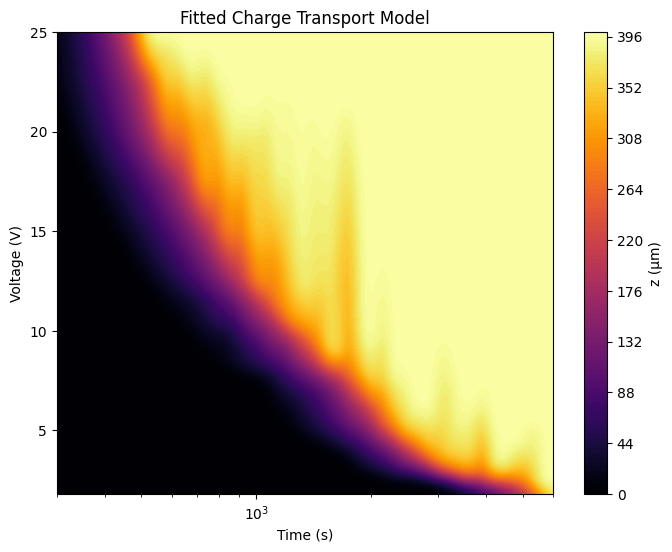

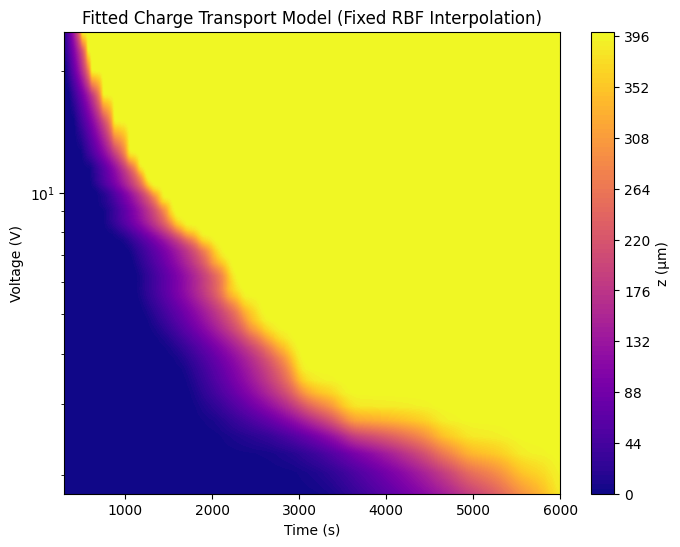

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
for V, t0, mu in zip(V_values, t0_values, mu_values):
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3Îã®Í≥Ñ: Ï§ëÎ≥µ Îç∞Ïù¥ÌÑ∞ Ï†úÍ±∞**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

# **4Îã®Í≥Ñ: RBF Î≥¥Í∞Ñ**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò epsilon ÏÑ§Ï†ï
)

# **5Îã®Í≥Ñ: Î≥¥Í∞ÑÎêú Grid ÏÉùÏÑ±**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **6Îã®Í≥Ñ: Gaussian ÌïÑÌÑ∞ Ï†ÅÏö©**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **7Îã®Í≥Ñ: Í∑∏ÎûòÌîÑ Ï∂úÎ†•**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')
# plt.xscale("log")
plt.yscale("log")
plt.colorbar(c, label="z (Œºm)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model (Fixed RBF Interpolation)")
plt.xlim(300, 6000)
plt.show()


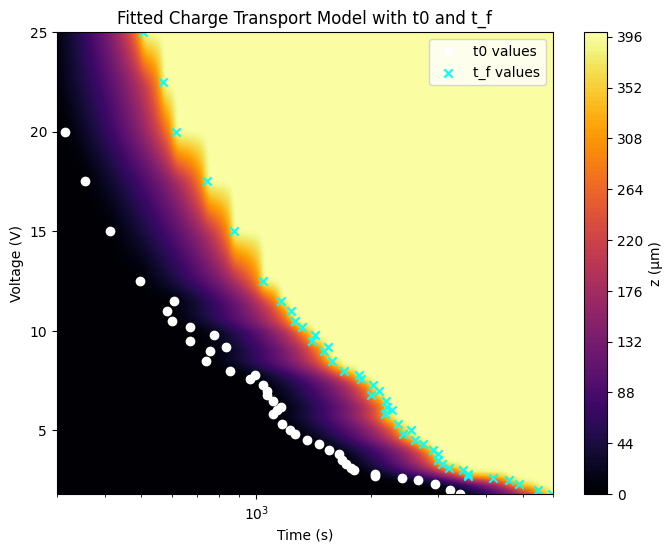

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
t_f_values = []  # ÏµúÏ¢Ö ÎèÑÎã¨ ÏãúÍ∞Ñ Ï†ÄÏû•

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f Í≥ÑÏÇ∞
    t_f_values.append(t_f)  # Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3Îã®Í≥Ñ: Ï§ëÎ≥µ Îç∞Ïù¥ÌÑ∞ Ï†úÍ±∞**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

# **4Îã®Í≥Ñ: RBF Î≥¥Í∞Ñ**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò epsilon ÏÑ§Ï†ï
)

# **5Îã®Í≥Ñ: Î≥¥Í∞ÑÎêú Grid ÏÉùÏÑ±**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **6Îã®Í≥Ñ: Gaussian ÌïÑÌÑ∞ Ï†ÅÏö©**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **7Îã®Í≥Ñ: Í∑∏ÎûòÌîÑ Ï∂úÎ†•**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='inferno')
plt.xscale("log")
plt.colorbar(c, label="z (Œºm)")

# **8Îã®Í≥Ñ: t0 Î∞è t_f Í∞í Ï∂îÍ∞Ä**
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # Ìù∞ÏÉâ Ïõê
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # ÌååÎûÄÏÉâ X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 1000)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
t_f_values = []  # ÏµúÏ¢Ö ÎèÑÎã¨ ÏãúÍ∞Ñ Ï†ÄÏû•

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f Í≥ÑÏÇ∞
    t_f_values.append(t_f)  # Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3Îã®Í≥Ñ: Ï§ëÎ≥µ Îç∞Ïù¥ÌÑ∞ Ï†úÍ±∞**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (Œºm)": z_list})
export_df.to_csv("data_export.csv", index=False)

# **4Îã®Í≥Ñ: RBF Î≥¥Í∞Ñ**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò epsilon ÏÑ§Ï†ï
)


# **5Îã®Í≥Ñ: Î≥¥Í∞ÑÎêú Grid ÏÉùÏÑ±**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **6Îã®Í≥Ñ: Gaussian ÌïÑÌÑ∞ Ï†ÅÏö©**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)
cmap_main = plt.get_cmap("inferno")  # Í∏∞Ï°¥ Ïª¨Îü¨Îßµ
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)
# **7Îã®Í≥Ñ: Í∑∏ÎûòÌîÑ Ï∂úÎ†•**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')
# **4Îã®Í≥Ñ: Ïª®Ìà¨Ïñ¥ ÎùºÏù∏ Ï∂îÍ∞Ä (z=0 Í∞ïÏ°∞)**
contour_levels = [5, 50, 100, 200, 300]
# plt.contour(T_grid, V_grid, Z_grid, levels=contour_levels, colors="white", linewidths=0.8)


plt.yscale("log")
plt.colorbar(c, label="z (Œºm)")

# **8Îã®Í≥Ñ: t0 Î∞è t_f Í∞í Ï∂îÍ∞Ä**
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # Ìù∞ÏÉâ Ïõê
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # ÌååÎûÄÏÉâ X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


PermissionError: [Errno 13] Permission denied: 'data_export.csv'

C:\Users\chemi\AppData\Local\Temp\ipykernel_16532\479902461.py:68: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(t_f_values, V_values, color="cyan", marker="x", edgecolors="none", label="t_f values")  # ÌååÎûÄÏÉâ X


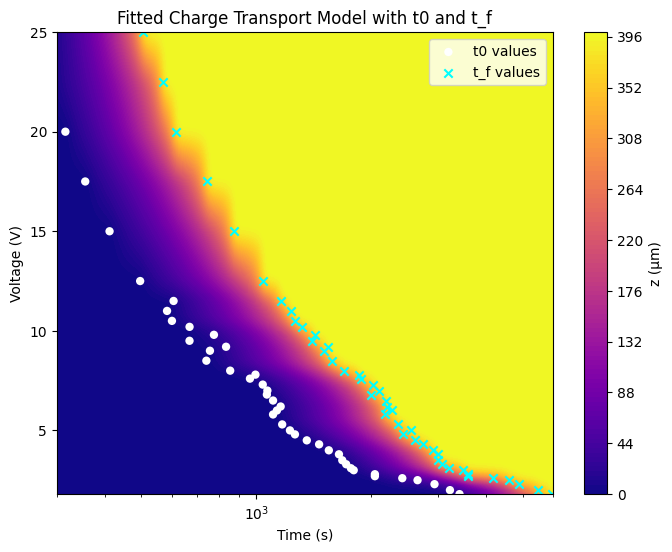

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_grid = np.linspace(min(V_values), max(V_values), 100)

V_list, t_list, z_list = [], [], []
t_f_values = []  # ÏµúÏ¢Ö ÎèÑÎã¨ ÏãúÍ∞Ñ Ï†ÄÏû•

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f Í≥ÑÏÇ∞
    t_f_values.append(t_f)  # Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3Îã®Í≥Ñ: RBF Î≥¥Í∞Ñ**
interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="linear",  # linearÎ°ú Î≥ÄÍ≤ΩÌïòÏó¨ Î∂ÄÎìúÎü¨Ïö¥ Î≥ÄÌôî
    epsilon=500  # Ï†ÅÏ†àÌïú smoothing (Îç∞Ïù¥ÌÑ∞Ïóê Îî∞Îùº Ï°∞Ï†ï Í∞ÄÎä•)
)

# **4Îã®Í≥Ñ: Î≥¥Í∞ÑÎêú Grid ÏÉùÏÑ±**
T_grid, V_grid = np.meshgrid(t_grid, V_grid)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **5Îã®Í≥Ñ: Gaussian ÌïÑÌÑ∞ Ï†ÅÏö©ÌïòÏó¨ Î∂ÄÎìúÎüΩÍ≤å**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.5)

# **6Îã®Í≥Ñ: Ïª¨Îü¨Îßµ ÏÑ§Ï†ï**
cmap = plt.get_cmap("plasma")  
norm = colors.Normalize(vmin=0, vmax=400)

# **7Îã®Í≥Ñ: Í∑∏ÎûòÌîÑ Ï∂úÎ†•**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap=cmap, norm=norm)

# **8Îã®Í≥Ñ: t0 Î∞è t_f Í∞í Ï∂îÍ∞Ä**
plt.scatter(t0_values, V_values, color="white", marker="o", edgecolors="none", label="t0 values")  # Ìù∞ÏÉâ Ïõê
plt.scatter(t_f_values, V_values, color="cyan", marker="x", edgecolors="none", label="t_f values")  # ÌååÎûÄÏÉâ X

plt.xscale("log")
plt.colorbar(c, label="z (Œºm)")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


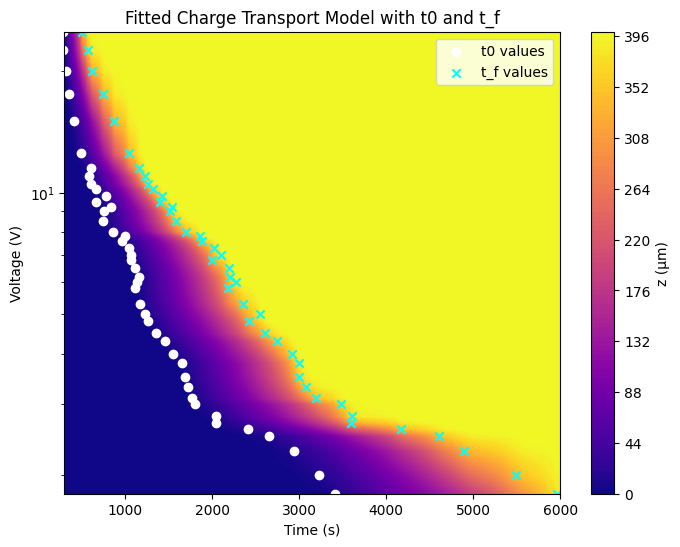

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_unique = np.unique(V_values)  # Î≥¥Í∞Ñ ÏóÜÏù¥ ÏõêÎûò V Í∞íÎßå ÏÇ¨Ïö©

V_list, t_list, z_list = [], [], []
t_f_values = []  # ÏµúÏ¢Ö ÎèÑÎã¨ ÏãúÍ∞Ñ Ï†ÄÏû•

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f Í≥ÑÏÇ∞
    t_f_values.append(t_f)  # Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)


# **4Îã®Í≥Ñ: Ï§ëÎ≥µ Îç∞Ïù¥ÌÑ∞ Ï†úÍ±∞**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]
# **3Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ CSVÎ°ú Ï†ÄÏû•**
export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (Œºm)": z_list})
export_df.to_csv("data_export2.csv", index=False)

# **5Îã®Í≥Ñ: RBF Î≥¥Í∞Ñ**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò epsilon ÏÑ§Ï†ï
)

# **6Îã®Í≥Ñ: Î≥¥Í∞ÑÎêú Grid ÏÉùÏÑ± (V Í∞í Î≥¥Í∞Ñ ÏóÜÏù¥ ÏõêÎûò Í∞íÎßå ÏÇ¨Ïö©)**
T_grid, V_grid = np.meshgrid(t_grid, V_unique)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **7Îã®Í≥Ñ: Gaussian ÌïÑÌÑ∞ Ï†ÅÏö©**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **8Îã®Í≥Ñ: Ïª¨Îü¨Îßµ ÏÑ§Ï†ï**
cmap_main = plt.get_cmap("inferno")  # Í∏∞Ï°¥ Ïª¨Îü¨Îßµ
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

# **9Îã®Í≥Ñ: Í∑∏ÎûòÌîÑ Ï∂úÎ†•**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')

# **10Îã®Í≥Ñ: Î°úÍ∑∏ Ïä§ÏºÄÏùº, Ïª¨Îü¨Î∞î, t0 Î∞è t_f Í∞í Ï∂îÍ∞Ä**
plt.yscale("log")
plt.colorbar(c, label="z (Œºm)")
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # Ìù∞ÏÉâ Ïõê
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # ÌååÎûÄÏÉâ X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


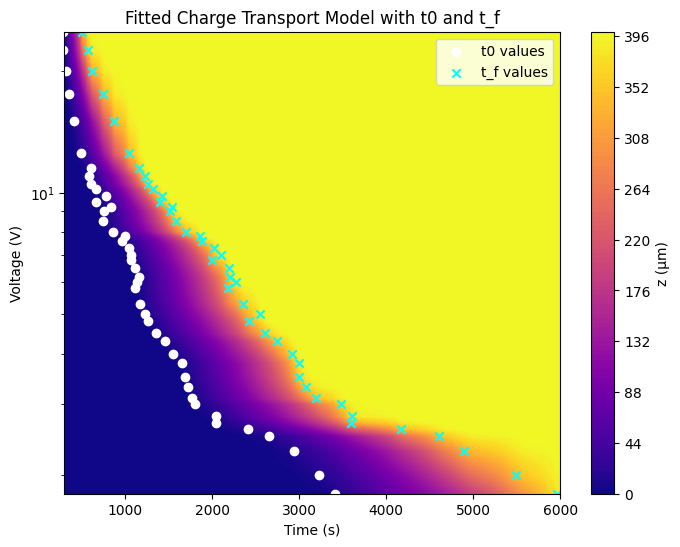

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.spatial.distance import pdist
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings_filled.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_values[np.isnan(t0_values)] = t0_interp(V_values[np.isnan(t0_values)])
mu_values[np.isnan(mu_values)] = mu_interp(V_values[np.isnan(mu_values)])

# **2Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)
V_unique = np.unique(V_values)  # Î≥¥Í∞Ñ ÏóÜÏù¥ ÏõêÎûò V Í∞íÎßå ÏÇ¨Ïö©

V_list, t_list, z_list = [], [], []
t_f_values = []  # ÏµúÏ¢Ö ÎèÑÎã¨ ÏãúÍ∞Ñ Ï†ÄÏû•

for V, t0, mu in zip(V_values, t0_values, mu_values):
    t_f = t0 + (L**2) / (2 * V * mu)  # t_f Í≥ÑÏÇ∞
    t_f_values.append(t_f)  # Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

# **3Îã®Í≥Ñ: Ï§ëÎ≥µ Îç∞Ïù¥ÌÑ∞ Ï†úÍ±∞**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

# **4Îã®Í≥Ñ: Ï§ëÎ≥µ Ï†úÍ±∞ ÌõÑ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•**
export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (Œºm)": z_list})
export_df.to_csv("data_export3.csv", index=False)

# **5Îã®Í≥Ñ: t0 Î∞è t_f Í∞í Ï†ÄÏû• (ÏõêÎûò Ï£ºÏñ¥ÏßÑ VÏóê ÎåÄÌï¥ÏÑúÎßå)**
t0_t_f_df = pd.DataFrame({"Voltage (V)": V_values, "t0 (s)": t0_values, "t_f (s)": t_f_values})
t0_t_f_df.to_csv("t0_tf_export.csv", index=False)

# **6Îã®Í≥Ñ: RBF Î≥¥Í∞Ñ**
distances = pdist(np.array([t_list, V_list]).T)
mean_dist = np.mean(distances)  

interp_func = RBFInterpolator(
    np.array([t_list, V_list]).T, 
    z_list, 
    kernel="multiquadric",  
    epsilon=mean_dist  # Îç∞Ïù¥ÌÑ∞ Í∏∞Î∞ò epsilon ÏÑ§Ï†ï
)

# **7Îã®Í≥Ñ: Î≥¥Í∞ÑÎêú Grid ÏÉùÏÑ± (V Í∞í Î≥¥Í∞Ñ ÏóÜÏù¥ ÏõêÎûò Í∞íÎßå ÏÇ¨Ïö©)**
T_grid, V_grid = np.meshgrid(t_grid, V_unique)
Z_grid = interp_func(np.array([T_grid.ravel(), V_grid.ravel()]).T).reshape(T_grid.shape)

# **8Îã®Í≥Ñ: Gaussian ÌïÑÌÑ∞ Ï†ÅÏö©**
Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=1.0)

# **9Îã®Í≥Ñ: Ïª¨Îü¨Îßµ ÏÑ§Ï†ï**
cmap_main = plt.get_cmap("inferno")  # Í∏∞Ï°¥ Ïª¨Îü¨Îßµ
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

# **10Îã®Í≥Ñ: Í∑∏ÎûòÌîÑ Ï∂úÎ†•**
plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap='plasma')

# **11Îã®Í≥Ñ: Î°úÍ∑∏ Ïä§ÏºÄÏùº, Ïª¨Îü¨Î∞î, t0 Î∞è t_f Í∞í Ï∂îÍ∞Ä**
plt.yscale("log")
plt.colorbar(c, label="z (Œºm)")
plt.scatter(t0_values, V_values, color="white", marker="o", label="t0 values")  # Ìù∞ÏÉâ Ïõê
plt.scatter(t_f_values, V_values, color="cyan", marker="x", label="t_f values")  # ÌååÎûÄÏÉâ X

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Fitted Charge Transport Model with t0 and t_f")
plt.xlim(300, 6000)
plt.legend()
plt.show()


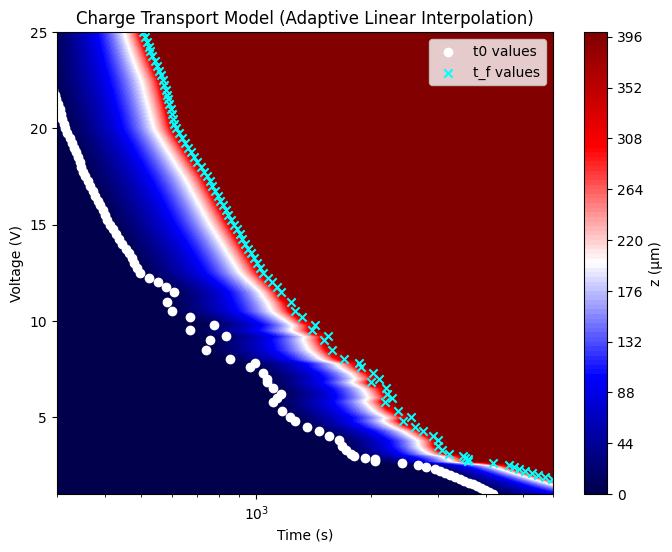

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

# **2Îã®Í≥Ñ: V Î≤îÏúÑÏóê Îî∞Îùº ÏÉàÎ°úÏö¥ V_fine ÏÉùÏÑ±**
V_low = np.arange(1, 3, 0.1)  # 3V ÎØ∏Îßå: 0.1V Í∞ÑÍ≤©
V_high = np.arange(11.5, max(V_values) + 5, 0.25)  # 11.5V Ïù¥ÏÉÅ: 0.25V Í∞ÑÍ≤©
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]  # 3V Ïù¥ÏÉÅ 11.5V ÎØ∏Îßå: Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Ïú†ÏßÄ

V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# **3Îã®Í≥Ñ: t0ÏôÄ muÏùò Î≥¥Í∞Ñ**
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# **4Îã®Í≥Ñ: t_f Î∞è z Í≥ÑÏÇ∞**
L = 400  
t_grid = np.logspace(np.log10(300), np.log10(6000), 200)

V_list, t_list, z_list = [], [], []
t_f_values = []

z_map = {}

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    t_f = t0 + (L**2) / (2 * V * mu)  
    t_f_values.append(t_f)

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

    z_map[V] = interp1d(t_grid, z_values, kind="linear", bounds_error=False, fill_value="extrapolate")

# **5Îã®Í≥Ñ: Ï§ëÎ≥µ Ï†úÍ±∞ Î∞è Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (Œºm)": z_list})
export_df.to_csv("data_export4.csv", index=False)

# **6Îã®Í≥Ñ: t0 Î∞è t_f Í∞í Ï†ÄÏû•**
t0_t_f_df = pd.DataFrame({"Voltage (V)": V_fine, "t0 (s)": t0_fine, "t_f (s)": t_f_values})
t0_t_f_df.to_csv("t0_tf_export4.csv", index=False)

# **7Îã®Í≥Ñ: Grid ÏÉùÏÑ± Î∞è ÌîåÎ°úÌåÖ**
T_grid, V_grid = np.meshgrid(t_grid, V_fine)
Z_grid = np.zeros_like(T_grid)

for i, V in enumerate(V_fine):
    Z_grid[i, :] = z_map[V](t_grid)

Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=0.5)

cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap=custom_cmap)

plt.xscale("log")
plt.colorbar(c, label="z (Œºm)")
plt.scatter(t0_fine, V_fine, color="white", marker="o", label="t0 values")
plt.scatter(t_f_values, V_fine, color="cyan", marker="x", label="t_f values")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model (Adaptive Linear Interpolation)")
plt.xlim(300, 6000)
plt.legend()
plt.show()


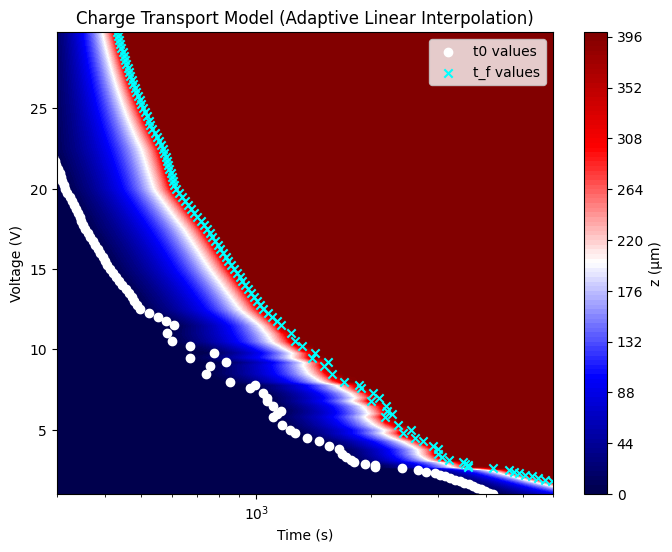

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

# **2Îã®Í≥Ñ: V Î≤îÏúÑÏóê Îî∞Îùº ÏÉàÎ°úÏö¥ V_fine ÏÉùÏÑ±**
V_low = np.arange(1, 3, 0.1)  # 3V ÎØ∏Îßå: 0.1V Í∞ÑÍ≤©
V_high = np.arange(11.5, max(V_values) + 5, 0.25)  # 11.5V Ïù¥ÏÉÅ: 0.25V Í∞ÑÍ≤©
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]  # 3V Ïù¥ÏÉÅ 11.5V ÎØ∏Îßå: Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Ïú†ÏßÄ

V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# **3Îã®Í≥Ñ: t0ÏôÄ muÏùò Î≥¥Í∞Ñ**
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# **4Îã®Í≥Ñ: t_f Î∞è z Í≥ÑÏÇ∞**
L = 400  
t_grid = np.logspace(np.log10(10), np.log10(6000), 1000)

V_list, t_list, z_list = [], [], []
t_f_values = []

z_map = {}

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    t_f = t0 + (L**2) / (2 * V * mu)  
    t_f_values.append(t_f)

    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_grid - t0), 0))
    z_values = np.clip(z_values, 0, 400)

    V_list.extend([V] * len(t_grid))
    t_list.extend(t_grid)
    z_list.extend(z_values)

    z_map[V] = interp1d(t_grid, z_values, kind="linear", bounds_error=False, fill_value="extrapolate")

# **5Îã®Í≥Ñ: Ï§ëÎ≥µ Ï†úÍ±∞ Î∞è Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•**
data = np.array([t_list, V_list, z_list]).T
unique_data = np.unique(data, axis=0)  
t_list, V_list, z_list = unique_data[:, 0], unique_data[:, 1], unique_data[:, 2]

export_df = pd.DataFrame({"Time (s)": t_list, "Voltage (V)": V_list, "z (Œºm)": z_list})
export_df.to_csv("data_export5.csv", index=False)

# **6Îã®Í≥Ñ: t0 Î∞è t_f Í∞í Ï†ÄÏû•**
t0_t_f_df = pd.DataFrame({"Voltage (V)": V_fine, "t0 (s)": t0_fine, "t_f (s)": t_f_values})
t0_t_f_df.to_csv("t0_tf_export5.csv", index=False)

# **7Îã®Í≥Ñ: Grid ÏÉùÏÑ± Î∞è ÌîåÎ°úÌåÖ**
T_grid, V_grid = np.meshgrid(t_grid, V_fine)
Z_grid = np.zeros_like(T_grid)

for i, V in enumerate(V_fine):
    Z_grid[i, :] = z_map[V](t_grid)

Z_grid = np.clip(Z_grid, 0, 400)
Z_grid = gaussian_filter(Z_grid, sigma=0.5)

cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

plt.figure(figsize=(8, 6))
c = plt.contourf(T_grid, V_grid, Z_grid, levels=100, cmap=custom_cmap)

plt.xscale("log")
plt.colorbar(c, label="z (Œºm)")
plt.scatter(t0_fine, V_fine, color="white", marker="o", label="t0 values")
plt.scatter(t_f_values, V_fine, color="cyan", marker="x", label="t_f values")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model (Adaptive Linear Interpolation)")
plt.xlim(300, 6000)
plt.legend()
plt.show()

In [52]:
import numpy as np
import csv

def interpolate_color(start, end, steps):
    """startÏóêÏÑú endÎ°ú ÏÑ†Ìòï Î≥¥Í∞ÑÎêú RGB Í∞íÏùÑ ÏÉùÏÑ±"""
    return np.linspace(start, end, steps, dtype=int)

# ÏÉâÏÉÅ Î≥ÄÌôò Íµ¨Í∞Ñ ÏÑ§Ï†ï
color_stops = [
    (255, 0, 0),   # Îπ®Í∞ï
    (255, 255, 0), # ÎÖ∏Îûë
    (0, 255, 0),   # Ï¥àÎ°ù
    (0, 255, 255), # ÏãúÏïà
    (0, 0, 255)    # ÌååÎûë
]

# 4Í∞úÏùò Íµ¨Í∞ÑÏúºÎ°ú 255Í∞ú Ï†êÏùÑ Í∑†Îì± Î∂ÑÎ∞∞
num_steps = [11, 11, 11, 11]  # Ï¥ù 255Í∞úÍ∞Ä ÎêòÎèÑÎ°ù Ï°∞Ï†ï

# Î≥¥Í∞ÑÎêú ÏÉâÏÉÅ Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
colors = []
for i in range(len(color_stops) - 1):
    start, end = color_stops[i], color_stops[i+1]
    interpolated = interpolate_color(start, end, num_steps[i])
    colors.extend(interpolated[:-1])  # Ï§ëÎ≥µ Î∞©ÏßÄÎ•º ÏúÑÌï¥ ÎßàÏßÄÎßâ Í∞í Ï†úÏô∏

# ÎßàÏßÄÎßâ ÏÉâÏÉÅÏùÑ Ï∂îÍ∞ÄÌïòÏó¨ 255Í∞ú ÎßûÏ∂îÍ∏∞
colors.append(color_stops[-1])

# Î∞∞Ïó¥ÏùÑ Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò
colors = [tuple(color) for color in colors]

# CSV ÌååÏùºÎ°ú Ï†ÄÏû•
csv_filename = "colors2.csv"
with open(csv_filename, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["R", "G", "B"])  # Ìó§Îçî ÏûëÏÑ±
    writer.writerows(colors)  # Îç∞Ïù¥ÌÑ∞ ÏûëÏÑ±

print(f"CSV ÌååÏùº '{csv_filename}' Ï†ÄÏû• ÏôÑÎ£å! (Ï¥ù {len(colors)}Í∞ú)")


CSV ÌååÏùº 'colors2.csv' Ï†ÄÏû• ÏôÑÎ£å! (Ï¥ù 41Í∞ú)


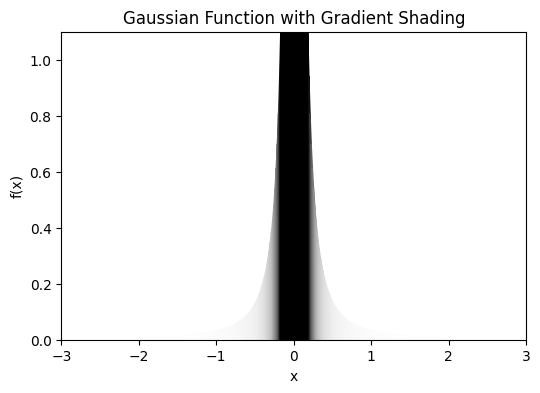

<Figure size 640x480 with 0 Axes>

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Í∞ÄÏö∞ÏãúÏïà Ìï®Ïàò Ï†ïÏùò
def gaussian(x, mu=0, sigma=1, a=1):
    #return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return 1/x**2/30
    
# x Î≤îÏúÑ ÏÑ§Ï†ï
x = np.linspace(-3, 3, 400)
y = gaussian(x, mu=0, sigma=1, a=1)

# Ïª¨Îü¨Îßµ ÏÑ§Ï†ï (ÌöåÏÉâ Í∑∏ÎùºÎç∞Ïù¥ÏÖò)
cmap = cm.Greys  # Ïó∞Ìïú ÌöåÏÉâ -> ÏßÑÌïú ÌöåÏÉâ (Î∞òÏ†ÑÎêú Greys Ïª¨Îü¨Îßµ)
norm = Normalize(vmin=0, vmax=1)  # Ï†ïÍ∑úÌôî

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
fig, ax = plt.subplots(figsize=(6, 4))

# Í∑∏ÎùºÎç∞Ïù¥ÏÖò Ï±ÑÏö∞Í∏∞
for i in range(len(x) - 1):
    ax.fill_between(
        [x[i], x[i+1]],  # x Íµ¨Í∞Ñ
        [y[i], y[i+1]],  # ÏÉÅÎã® Í≤ΩÍ≥Ñ
        color=cmap(norm(y[i]))  # y Í∞íÏóê Îî∞Îùº ÏÉâÏÉÅ Ï†ÅÏö©
    )

# Ï∂ï ÏÑ§Ï†ï
ax.set_xlim(-3, 3)
ax.set_ylim(0, 1.1)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("Gaussian Function with Gradient Shading")

plt.show()
plt.savefig("output.png")


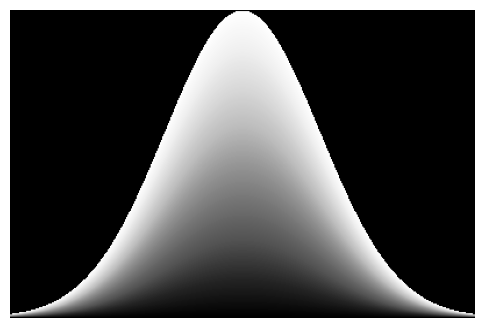

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Í∞ÄÏö∞ÏãúÏïà Ìï®Ïàò Ï†ïÏùò
def gaussian(x, mu=0, sigma=1, a=1):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# x Î≤îÏúÑ ÏÑ§Ï†ï
x = np.linspace(-3, 3, 400)
y = gaussian(x, mu=0, sigma=1, a=1)

# Ïù¥ÎØ∏ÏßÄÏö© Í∑∏Î¶¨Îìú ÏÉùÏÑ±
X, Y = np.meshgrid(x, np.linspace(0, 1, 256))  # y Î∞©Ìñ• Í∑∏Î¶¨Îìú
Y_max = gaussian(X, mu=0, sigma=1, a=1)  # Í∞Å xÏóêÏÑú Í∞ÄÏö∞ÏãúÏïàÏùò ÏµúÎåÄÍ∞í

# ‚úÖ 0 ~ 1 ÏÑ†Ìòï Ïä§ÏºÄÏùºÎßÅ Ï†ÅÏö© (forÎ¨∏ ÏóÜÏù¥ Ï†ÑÏ≤¥ Í≥ÑÏÇ∞)
alpha_values = np.clip(Y / Y_max, 0, 1)  # 0~1 ÏÇ¨Ïù¥Î°ú Ï†ïÍ∑úÌôî
alpha_values[Y > Y_max] = 0  # Í∞ÄÏö∞ÏãúÏïà ÏòÅÏó≠ Î∞îÍπ•ÏùÄ 0 (ÏôÑÏ†Ñ Ìà¨Î™Ö)

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
fig, ax = plt.subplots(figsize=(6, 4))

ax.imshow(
    alpha_values,  # Ìà¨Î™ÖÎèÑ ÌñâÎ†¨
    extent=[-3, 3, 0, 1],  # xÏôÄ yÏùò Î≤îÏúÑ
    origin="lower",
    cmap="Greys_r",  # ÌöåÏÉâ Í∑∏ÎùºÎç∞Ïù¥ÏÖò
    aspect="auto"
)

# ‚úÖ Ï∂ïÍ≥º ÎùºÎ≤® Ïà®ÍπÄ (Ïô∏Í≥ΩÏÑ† Ï†úÍ±∞)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# ‚úÖ Î∞∞Í≤ΩÏù¥ Ìà¨Î™ÖÌïú PNGÎ°ú Ï†ÄÏû•
plt.savefig("gaussian_gradient_linear.png", transparent=True, dpi=300)

plt.show()

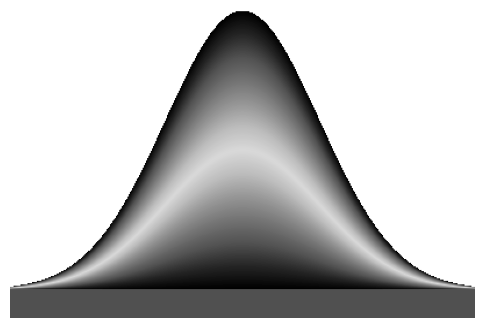

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Í∞ÄÏö∞ÏãúÏïà Ìï®Ïàò Ï†ïÏùò
def gaussian(x, mu=0, sigma=1, a=1):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# x Î≤îÏúÑ ÏÑ§Ï†ï
x = np.linspace(-3, 3, 400)
y = gaussian(x, mu=0, sigma=1, a=1)

# Ïù¥ÎØ∏ÏßÄÏö© Í∑∏Î¶¨Îìú ÏÉùÏÑ±
X, Y = np.meshgrid(x, np.linspace(-0.1, 1, 256))  # ‚úÖ y Î≤îÏúÑ (-0.1 ~ 1)
Y_max = gaussian(X, mu=0, sigma=1, a=1)  # Í∞Å xÏóêÏÑú Í∞ÄÏö∞ÏãúÏïàÏùò ÏµúÎåÄÍ∞í

# ‚úÖ ÏÉâ Î≥ÄÌôî Ï†ÅÏö© (y = -0.1ÏóêÏÑú Ïó∞ÌïúÏÉâ ‚Üí y = 0ÏóêÏÑú ÏßÑÌïúÏÉâ ‚Üí y = f(x)ÏóêÏÑú Îã§Ïãú Ïó∞ÌïúÏÉâ)
alpha_values = np.zeros_like(Y)

# üéØ 1. xÏ∂ï ÏúÑ (y = 0 ~ f(x)): Ï§ëÍ∞ÑÏóêÏÑú ÏßÑÌïòÍ≤å, ÏúÑÎ°ú Í∞àÏàòÎ°ù Ïó∞ÌïòÍ≤å
mask_upper = (Y >= 0) & (Y <= Y_max)
alpha_values[mask_upper] = 0.2 + 0.6 * np.abs(1 - 2 * Y[mask_upper] / Y_max[mask_upper])  # Ï§ëÍ∞ÑÏù¥ Í∞ÄÏû• ÏßÑÌï®

# üéØ 2. xÏ∂ï ÏïÑÎûò (y = -0.1 ~ 0): ÏùºÏ†ïÌïú ÏÉâ (Ïó∞Ìïú ÌöåÏÉâ, Ïòà: 0.6)
mask_lower = (Y < 0)
alpha_values[mask_lower] = 0.6  

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
fig, ax = plt.subplots(figsize=(6, 4))

ax.imshow(
    alpha_values,  # Ìà¨Î™ÖÎèÑ ÌñâÎ†¨
    extent=[-3, 3, -0.1, 1],  # ‚úÖ y Î≤îÏúÑ (-0.1 ~ 1)
    origin="lower",
    cmap="Greys",  # ÌöåÏÉâ Í∑∏ÎùºÎç∞Ïù¥ÏÖò
    aspect="auto"
)

# ‚úÖ Ï∂ïÍ≥º ÎùºÎ≤® Ïà®ÍπÄ (Ïô∏Í≥ΩÏÑ† Ï†úÍ±∞)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# ‚úÖ Î∞∞Í≤ΩÏù¥ Ìà¨Î™ÖÌïú PNGÎ°ú Ï†ÄÏû•
plt.savefig("gaussian_gradient_symmetric.png", transparent=True, dpi=300)

plt.show()


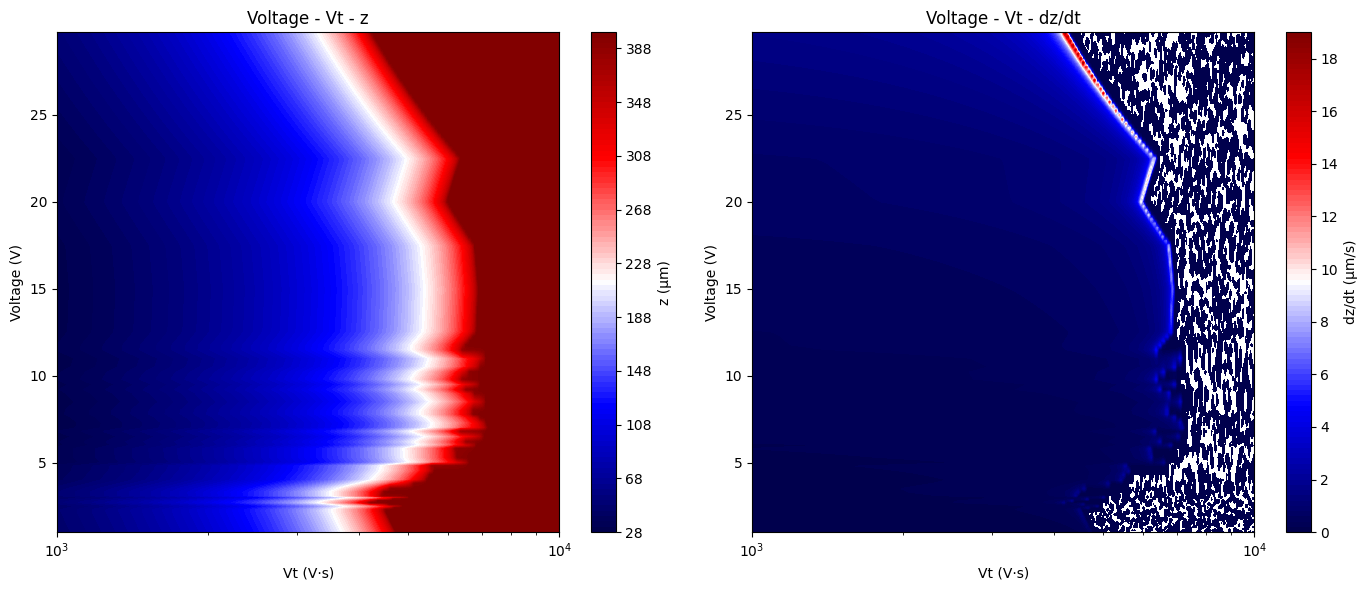

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

# V Î≤îÏúÑ ÏÑ§Ï†ï
V_low = np.arange(1, 3, 0.1)
V_high = np.arange(11.5, max(V_values) + 5, 0.25)
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]
V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# Î≥¥Í∞Ñ
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# Vt Í∑∏Î¶¨Îìú ÏÑ§Ï†ï
Vt_min, Vt_max = 1e3, 1e4  # VtÏùò ÏµúÏÜå, ÏµúÎåÄ Î≤îÏúÑ
Vt_grid = np.logspace(np.log10(Vt_min), np.log10(Vt_max), 400)

V_list, Vt_list, z_list, dzdt_list = [], [], [], []
z_map = {}
dzdt_map = {}

L = 400

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    t_f = t0 + (L**2) / (2 * V * mu)
    
    t_values = t0 + Vt_grid / V  # Vt = V * (t - t0) Ï†ïÏùò
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_values - t0), 0))
    z_values = np.clip(z_values, 0, 400)
    dzdt_values = np.gradient(z_values, t_values)  # dz/dt Í≥ÑÏÇ∞
    
    V_list.extend([V] * len(Vt_grid))
    Vt_list.extend(Vt_grid)
    z_list.extend(z_values)
    dzdt_list.extend(dzdt_values)
    
    z_map[V] = interp1d(Vt_grid, z_values, kind="linear", bounds_error=False, fill_value="extrapolate")
    dzdt_map[V] = interp1d(Vt_grid, dzdt_values, kind="linear", bounds_error=False, fill_value="extrapolate")

# Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
data_df = pd.DataFrame({"Voltage (V)": V_list, "Vt (V‚ãÖs)": Vt_list, "z (Œºm)": z_list, "dz/dt (Œºm/s)": dzdt_list})
data_df.to_csv("data_export_vt.csv", index=False)

# Grid ÏÉùÏÑ±
Vt_mesh, V_mesh = np.meshgrid(Vt_grid, V_fine)
Z_grid = np.zeros_like(Vt_mesh)
DZDT_grid = np.zeros_like(Vt_mesh)

for i, V in enumerate(V_fine):
    Z_grid[i, :] = z_map[V](Vt_grid)
    DZDT_grid[i, :] = dzdt_map[V](Vt_grid)

Z_grid = gaussian_filter(np.clip(Z_grid, 0, 400), sigma=0.5)
DZDT_grid = gaussian_filter(DZDT_grid, sigma=0.5)

# ÌîåÎ°úÌåÖ
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

# Ï≤´ Î≤àÏß∏ Ïª¨Îü¨Îßµ (Vt - z)
c1 = axes[0].contourf(Vt_mesh, V_mesh, Z_grid, levels=100, cmap=custom_cmap)
axes[0].set_xscale("log")
axes[0].set_xlabel("Vt (V‚ãÖs)")
axes[0].set_ylabel("Voltage (V)")
axes[0].set_title("Voltage - Vt - z")
fig.colorbar(c1, ax=axes[0], label="z (Œºm)")

# Îëê Î≤àÏß∏ Ïª¨Îü¨Îßµ (Vt - dz/dt)
c2 = axes[1].contourf(Vt_mesh, V_mesh, DZDT_grid, levels=100, cmap=custom_cmap)
axes[1].set_xscale("log")
axes[1].set_xlabel("Vt (V‚ãÖs)")
axes[1].set_ylabel("Voltage (V)")
axes[1].set_title("Voltage - Vt - dz/dt")
fig.colorbar(c2, ax=axes[1], label="dz/dt (Œºm/s)")

plt.tight_layout()
plt.show()

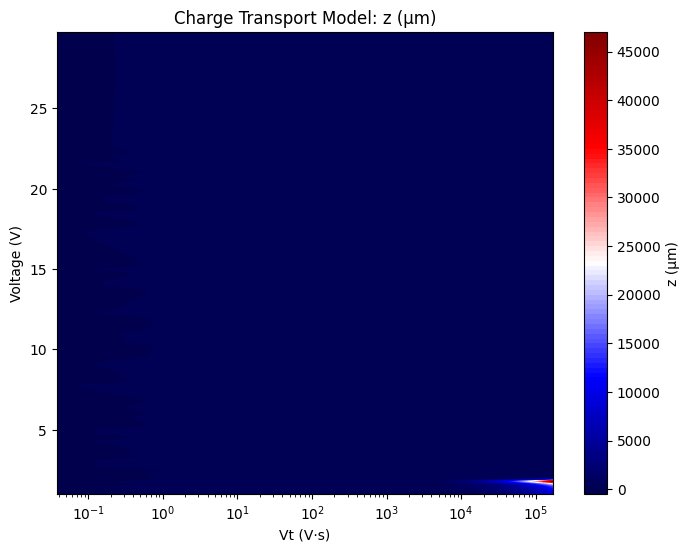

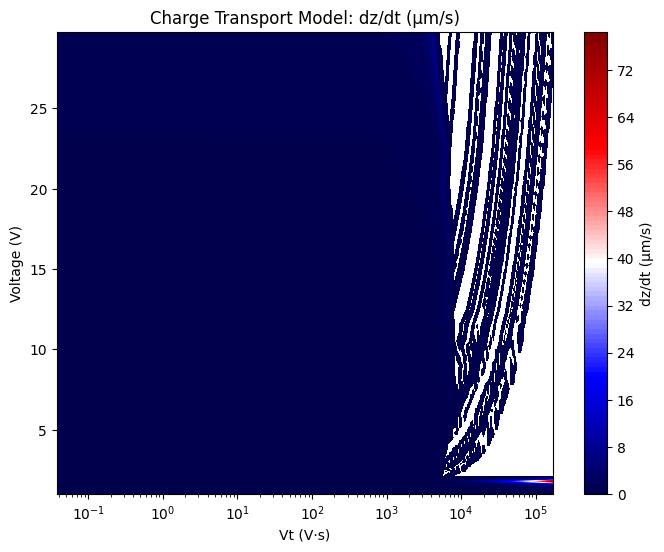

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# **1Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Î°úÎìú**
fitting_df = pd.read_csv("fittings.csv")
V_values = fitting_df["V"].values
t0_values = fitting_df["t0"].values
mu_values = fitting_df["mu"].values * 1e8  # cm¬≤ ‚Üí Œºm¬≤ Î≥ÄÌôò

# **2Îã®Í≥Ñ: V Î≤îÏúÑÏóê Îî∞Îùº ÏÉàÎ°úÏö¥ V_fine ÏÉùÏÑ±**
V_low = np.arange(1, 3, 0.1)  # 3V ÎØ∏Îßå: 0.1V Í∞ÑÍ≤©
V_high = np.arange(11.5, max(V_values) + 5, 0.25)  # 11.5V Ïù¥ÏÉÅ: 0.25V Í∞ÑÍ≤©
V_mid = V_values[(V_values >= 3) & (V_values < 11.5)]  # 3V Ïù¥ÏÉÅ 11.5V ÎØ∏Îßå: Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Ïú†ÏßÄ

V_fine = np.sort(np.concatenate([V_low, V_mid, V_high]))

# **3Îã®Í≥Ñ: t0ÏôÄ muÏùò Î≥¥Í∞Ñ**
valid_mask_t0 = ~np.isnan(t0_values)
valid_mask_mu = ~np.isnan(mu_values)

t0_interp = interp1d(V_values[valid_mask_t0], t0_values[valid_mask_t0], kind="linear", fill_value="extrapolate")
mu_interp = interp1d(V_values[valid_mask_mu], mu_values[valid_mask_mu], kind="linear", fill_value="extrapolate")

t0_fine = t0_interp(V_fine)
mu_fine = mu_interp(V_fine)

# **4Îã®Í≥Ñ: Vt Î∞è z Í≥ÑÏÇ∞**
L = 400  
t_grid = np.logspace(np.log10(10), np.log10(6000), 400)

V_list, Vt_list, z_list, dzdt_list = [], [], [], []

def compute_z(V, t0, mu, t_values):
    z_values = L - np.sqrt(np.maximum(L**2 - 2 * V * mu * (t_values - t0), 0))
    z_values = np.clip(z_values, 0, 400)
    dzdt_values = np.gradient(z_values, t_values)
    return z_values, dzdt_values

for V, t0, mu in zip(V_fine, t0_fine, mu_fine):
    Vt_values = V * (t_grid - t0)
    valid_mask = Vt_values > 0
    Vt_values = Vt_values[valid_mask]
    t_valid = t_grid[valid_mask]
    
    z_values, dzdt_values = compute_z(V, t0, mu, t_valid)
    
    V_list.extend([V] * len(Vt_values))
    Vt_list.extend(Vt_values)
    z_list.extend(z_values)
    dzdt_list.extend(dzdt_values)

# **5Îã®Í≥Ñ: Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•**
data_df = pd.DataFrame({"Voltage (V)": V_list, "Vt (V‚ãÖs)": Vt_list, "z (Œºm)": z_list, "dz/dt (Œºm/s)": dzdt_list})
data_df.to_csv("data_export_vt.csv", index=False)

# **6Îã®Í≥Ñ: Grid ÏÉùÏÑ± Î∞è ÌîåÎ°úÌåÖ**
Vt_grid = np.logspace(np.log10(min(Vt_list)), np.log10(max(Vt_list)), 400)
V_grid = np.unique(V_list)
Z_grid = np.zeros((len(V_grid), len(Vt_grid)))
dZdt_grid = np.zeros_like(Z_grid)

for i, V in enumerate(V_grid):
    mask = np.array(V_list) == V
    interp_z = interp1d(np.array(Vt_list)[mask], np.array(z_list)[mask], kind="linear", fill_value="extrapolate")
    interp_dzdt = interp1d(np.array(Vt_list)[mask], np.array(dzdt_list)[mask], kind="linear", fill_value="extrapolate")
    Z_grid[i, :] = interp_z(Vt_grid)
    dZdt_grid[i, :] = interp_dzdt(Vt_grid)

Z_grid = gaussian_filter(Z_grid, sigma=0.5)
dZdt_grid = gaussian_filter(dZdt_grid, sigma=0.5)

cmap_main = plt.get_cmap("seismic")
cmap_colors = ["black"] + [cmap_main(i) for i in np.linspace(0, 1, 256)]
custom_cmap = colors.ListedColormap(cmap_colors)

plt.figure(figsize=(8, 6))
c1 = plt.contourf(Vt_grid, V_grid, Z_grid, levels=100, cmap=custom_cmap)
plt.xscale("log")
plt.colorbar(c1, label="z (Œºm)")
plt.xlabel("Vt (V‚ãÖs)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model: z (Œºm)")
plt.show()

plt.figure(figsize=(8, 6))
c2 = plt.contourf(Vt_grid, V_grid, dZdt_grid, levels=100, cmap=custom_cmap)
plt.xscale("log")
plt.colorbar(c2, label="dz/dt (Œºm/s)")
plt.xlabel("Vt (V‚ãÖs)")
plt.ylabel("Voltage (V)")
plt.title("Charge Transport Model: dz/dt (Œºm/s)")
plt.show()
